$\large \texttt{ Nacereddine LADDAOUI, M2} \\
 \large \texttt{ Student number : 28615650} $

$$\large \texttt{ Tutorial 2, Face-Alignment using regressors} $$ 

<font size="3" >
    
Face-Alignment is a technique in which we search to align a face mask onto an image, so that each point of the mask get his way to it corresponding position on the face. More specifically, we will use a regression technique that will estimate the required displacement for a mean landmark model to fit exactly the face, and this using a __Least squares approximation__.
    
</font>

# $ \texttt{import libraries} $

In [ ]:
import skimage
import cv2 as cv
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


#  $\texttt{I. Data preparation} $

## $\texttt{1. The dataset}$

<font size="3" >
The provided dataset $\texttt{300w}$ for this tutorial came with a set of people faces from 4 other datasets $\texttt{fpw, helen, ibug, lfpw}$. The first step in the tutorial is to prepare the dataset following the defined instructions in PDF. 

Our dataset is constituted of __3148__ examples for the train and __689__ examples for the test. Each sample have the annotated position of ___68___ face landmarks in the corresponding `.pts` file. This next figure shows the face model template that is used with the position of each landmark.
    
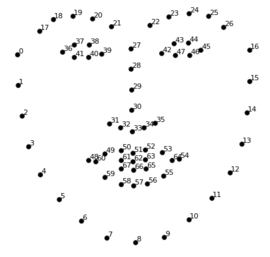
    
The preprocessing steps are the following :
- Compute the ___bounding box___ using the landmarks, and enhanced it by 30 %.
- ___Crop___ the image to the computed bbox.
- ___Resize___ to an 128x128 px image.
- The saved landmarks for each image are computed according to the original image, so in order to adapt them on the resized image, we need :
    - Subtract the $(x_{min}, y_{min})$ from the landmark model.
    - Rescale its width and height, to get into the 128 x 128 image.
    
    We model this transformation by the next formula :
    
$$ \texttt{new}\_\texttt{landmarks}_{[68 \times 2]} \quad = \quad \left( \texttt{landmarks} - \left[ \texttt{x}_\texttt{min}, \texttt{y}_\texttt{min} \right] \right)_{[68 \times 2]} \begin{pmatrix}
\dfrac{\texttt{128}}{\texttt{x}_\texttt{max} - \texttt{x}_\texttt{min}} & \texttt{0} \\
\texttt{0} & \dfrac{\texttt{128}}{\texttt{y}_\texttt{max} - \texttt{y}_\texttt{min}}
\end{pmatrix}_{[2 \times 2]}$$

where $\texttt{x}_\texttt{min},  \texttt{y}_\texttt{min},  \texttt{x}_\texttt{max},  \texttt{y}_\texttt{max}$ are the delimitation do the bounding box
    
    
</font>

## $\texttt{2. Build dataset}$

<font size="3" >
    
The following cell creates the dataset we need for the train and test steps. In order to this function should execute, this notebook should be place on the same directory that contains the __`300w/`__ folder. This operation creates a dataset folder, where all the preprocessed images are stored :
    
__```
dataset / 
        trainset /
                images /
                landmarks /
        testset  /
                images /
                landmarks /
```__
    
> In order to execute the following cell, this notebook must be outside the `300w/` dataset, as well as the utils.py file

</font>

In [ ]:
import os
from utils import build_dataset

if not os.path.exists("./dataset/checksum.txt") :
    # Path to the `300w/` dataset
    dataset_path = Path("./300w/")
    # build
    build_dataset(dataset_path)
else :
    print("Dataset already exists !")

## $ \texttt{3. Load the dataset }$

In [ ]:
from utils import plot_samples
from skimage.color import rgb2gray

# Load the images
train_images    = skimage.io.imread_collection('./dataset/trainset/images/*')
# Load the landmarks
train_landmarks = [np.load(ldk) for ldk in sorted(Path('./dataset/trainset/landmarks/').glob("*"))]
# Show some samples from the trainset
plot_samples(train_images, train_landmarks, n = 5)

## $ \texttt{4. Compute the mean mask}$

In [ ]:
# compute of a mean model on all images
mean_model = np.mean(train_landmarks, axis = 0)

# plot it
fig = plt.figure(figsize = (5,5))
plt.scatter(*mean_model.T, marker = '+', color = 'red')
plt.xlim(0,128)
plt.ylim(128, 0) # invert y axis 
plt.axis('off')
plt.title("Mean landmark model")
plt.show()

<font size="3" >

The mean model is computed using all the landmarks of the training set. Some existing samples of the dataset have various _landmarks positions_ which is caused by various ___head orientations, head shapes and face expressions___, but the majority doesn't expose such variations. And we can see from the previous figure that all the landmarks represents a converge to a __standard__ face model.
    
</font>

## $\texttt{5. Transformations}$

<font size="3" >

We operate random transformation on the mean model, by augmenting data and extract various features from the image , and this in order to create variability in the learning process and learn multiple patterns from data.
    
The specified transformations in the tutorial are __translation__ and __rescaling__, but we can also add a __rotation__ parameter that will rotate the model by a specific angle. To do so, we can set a general formula that uses all these parameters at once :

$$ 
\begin{align}
\texttt{transformed}\_\texttt{landmarks}_{[68 \times 2]} \quad &=  \texttt{f}(\texttt{landmarks}, \texttt{t}_x, \texttt{t}_y, \texttt{s}_x, \texttt{s}_y, \theta) \\
    &= \quad \texttt{landmarks}_{[68 \times 2]} \begin{pmatrix}
\texttt{s}_x \texttt{cos($\theta$)} & - \texttt{s}_x \texttt{sin($\theta$)}  \\
\texttt{s}_y \texttt{sin($\theta$)} &   \texttt{s}_y \texttt{cos($\theta$)}
\end{pmatrix}_{[2 \times 2]}
+ \quad
\begin{pmatrix}
\texttt{t}_x   \\
\texttt{t}_y
\end{pmatrix}_{[2 \times 1]}
\end{align}
$$
    
</font>

In [ ]:
from utils import create_transformation

# Create model transformation by 'rescaling' , 'translation' and 'rotation'
t_landmarks = create_transformation(mean_model, n = 10, rotation = 15 )
plot_samples(np.ones((10,128,128,3)),t_landmarks, n= 10)

# $\texttt{II. Detailed steps of the algorithm}$

<font size="3" > 
In the following cells, we will unfold the algorithm to follow the extraction steps defined in the tutorial
</font>

## $ \texttt{1. Extract image characteristics }$

<font size="3" >
    
A __descriptor__ is a set of features that describes a region of an image. In our context, we need to describe an area surrounding a particular point of interest or keypoint. The effectiveness of these characteristics depends on the type of descriptor extractor used.
    
Thus, we can't use the pixel value as a descriptor of a keypoint because this description doesn't offer a meaningful information and features. By this we mean that this isn't a discriminative representation. Thus this isn't a good feature to use. Instead we can use __Scale Invariant Feature Transform (SIFT)__ feature extractor that is used to identify and extract distinctive features from images. This descriptor is very popular among the computer vision community and it is widely used in various application such as matching between two images and object recognition,  due to its robustness and effectiveness.
    

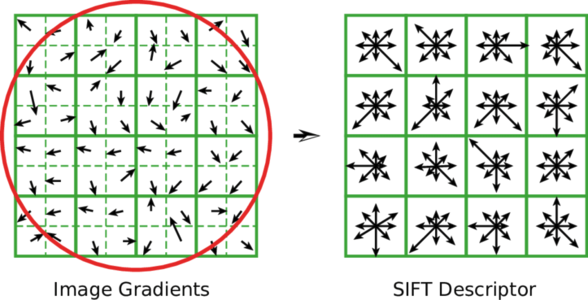
</font>


In [ ]:
# create a cv.KeyPoint object for each landmark of the mean mask
mean_keypoints = [ cv.KeyPoint(*ld, size = 20) for ld in mean_model]

<font size="3" > 
    
__Data augmentation :__ For the same image, we generate 10 transformation of the mean landmark model. Which means that we will have 10 time more samples in the training set, in total __31480__ samples. The point of this operation is to enhance the dataset with different initial start position, so the SIFT detector can extract different features around each landmark for all the images in the augmented trainset.

</font> 

In [ ]:
from utils import to_keypoints

# total  train size = Trainset * NUMBER_of_Augmentations
TRAINSET_SIZE = len(train_images)
AUGMENTATIONS = 10

# Generate the transformations
_landmarks = create_transformation(mean_model, AUGMENTATIONS * TRAINSET_SIZE, rotation = 15)

# Turn them into keypoint objects
keypoints = [ to_keypoints(landmark) for landmark in _landmarks]

In [ ]:
# Extract desctiptors

descriptors = []
for ind in tqdm(range(0, AUGMENTATIONS * TRAINSET_SIZE), ncols = 100, desc ="Loading ") :
    sift = cv.SIFT_create()
    _keypts = keypoints[ind] 
    # Apply the sift algorithm
    kp, desc = sift.compute(train_images[ ind // AUGMENTATIONS], _keypts)
    # Store the descriotors
    descriptors.append( desc.flatten() )

In [ ]:
descriptors = np.array(descriptors)
print("Descriptors dim :", descriptors.shape)

## $\texttt{2. Principal Component Analysis (PCA)}$

 <font size="3" >

___Principal Component Analysis (PCA)___ is a common dimensionality reduction algorithm that projects samples from  higher dimension space to a lower one, this by keeping the best possible representation. In our application, the purpose of using it while learning, is to reduce the data feature vector size from $128 \times 68  = 8704 $ to a __number of components__ (the new spaces dimension) that we will determine. The PCA formula is like the following :
    
$$ \tilde{X_0}_{\texttt{[dim', samples]}} = {A_0}_{\texttt{[dim', dim]}} {X_0}_{\texttt{[dim, samples]}} $$
    
Where $\tilde{X_0}$ is the projected dataset in the new space, $X_0$ the representation in the initial feature space and $A_0$ the projection matrix. $\texttt{dim'}$ is the new dimension and $\texttt{dim}$ the previous one.
    
A good way of compute the representativity of the new dimensions is to calculate the __variance ratio__. This means how much variance of the dataset does the PCA keep. More this variance ratio is higher and near of 1 more the new representation of the dataset is faithful to the original.

   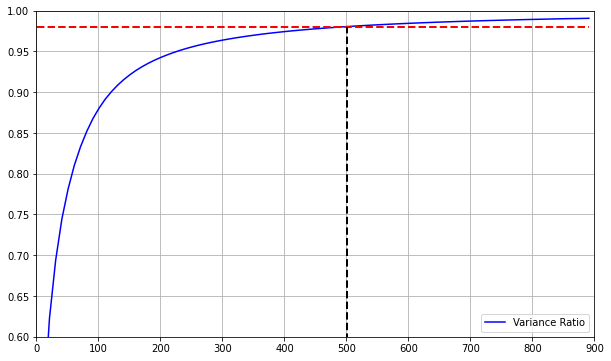 
    
In our case we choose to keep $\texttt{98}\%$ variance, and for that we will try multiple __dimension values__ and choose the first one to  fit our needs.
 
 
However the are a lot of other popular dimensionality reduction algorithms, but the most used ones __t-SNE ( T-distributed stochastic neighbor embedding )__ or more recently __UMAP ( Uniform Manifold Approximation and Projection )__, or even Neural Network architectures like __Autoencoders__
  
</font>

In [ ]:
from sklearn.decomposition import PCA

# Projection dim
# To obtain a variance ratio of 98%, we need to specify a different n_component 
# depending on the type of data augmentation introduiced to the trainset. 
# For instance, if we don't specify rotation, we only need 500 components, and  
# 620 components for a rotation of 15°
n_components = 620

# Compute the PCA
pca = PCA(n_components)
pca.fit(descriptors)
print(f"Variance ratio : {np.sum(pca.explained_variance_ratio_):4.3f}")

In [ ]:
A0 = pca.components_

# project the descriptors
descriptors = A0 @ descriptors.T
print("The new dataset dimension :",   descriptors.shape)

##  $ \texttt{3. Estimate the displacement }$

<font size="3" >
    
In the next step we will going to learn the parameters a regressor using the extracted and projected descriptors. Our goal is to approach the perfect fit $\delta_s^*$ using one layer of regression that computes a displacement $\delta_s^0$. The perfect fit $\delta_s^*$ is the distance between the annotated landmarks of the dataset and initial mask.
    
$$\delta_s^0=\operatorname{argmin}_{\delta_s}\left\|\delta_s^*-\delta_s\right\|^2$$

As said bellow we will use the descriptors of the previous step to estimate the displacement $ \delta_s $. Here we insert the regression formula depending on the previous descriptor,  $R_0 $ and biases $b_0$
$$
\operatorname{argmin}_{\tilde{R}_0, b_0}\left\|\delta_s^*-\tilde{R}_0 \tilde{\mathbf{X}}_0-b_0\right\|^2
$$
Meaning of the used notations :
- $X_0$ is the extracted descriptors on the dataset, where the projected descriptors of a sample are putted on one column ( the transpose matrix as it's defined in the code ). Its shape is $ M' \times N $.
- $R_0$ first parameter to learn. This  means to compute a combination of the $M'$ descriptors dimension for each sample in $X_0$. Its shape is $ 136 \times M'$. 
- $b_0$ second parameter to learn. Means the bias to add for each displacement dimension.  Its shape is $ 136 \times 1 $
    
Factorizing the previous equation :
$$
\operatorname{argmin}_{\tilde{R}_0, b_0}
\left\|\delta_s^*-
    \begin{pmatrix}
        \tilde{R}_0 & b_0
    \end{pmatrix} \times 
    \begin{pmatrix}
         \tilde{\mathbf{X}}_0 \\
         \mathbf{1} 
    \end{pmatrix}
\right\|^2 
$$
    
$$
\operatorname{argmin}_{\tilde{R}_0, b_0}
\left\|\delta_s^*-
       R_0 
     \times 
     \tilde{\mathbf{Y}}_0
\right\|^2 
$$
$$
\begin{align}
\tilde{\mathbf{Y}}_0 &=      \begin{pmatrix} \tilde{\mathbf{X}}_0 \\ \mathbf{1}  \end{pmatrix} && \text{shape : $\left( M'  + 1\right) \times N $} \\
R_0  &=  \begin{pmatrix} \tilde{R}_0 & b_0 \end{pmatrix}  && \text{shape : $136 \times \left( M'  + 1\right)$}
\end{align}
$$
</font>

## $\texttt{4. Least square approximation}$
<font size="3" >
    
Our goal is to minimize the cost function introduced earlier using __Least square method__, and then find the optimal regression parameters that optimizes the displacement on the train data :
    
$$
\begin{align}
L &=  \left\|\delta_s^*- R_0 \tilde{\mathbf{Y}}_0 \right\|^2 \\
  &=  \left( \delta_s^*- R_0 \tilde{\mathbf{Y}}_0 \right)^T \left(\delta_s^*- R_0  \tilde{\mathbf{Y}}_0 \right) \\
&= {\delta_s^*}^T \delta_s^* - {\delta_s^*}^T R_0 \tilde{\mathbf{Y}}_0  - \tilde{\mathbf{Y}}_0^T R_0^T \delta_s^* +  \tilde{\mathbf{Y}}_0^T R_0^T R_0 \tilde{\mathbf{Y}}_0
\end{align}
$$
    
Derivate the loss on $R_0$    
$$
\begin{align}
\dfrac{\partial L}{\partial R_0} &= \dfrac{ \partial \left( {\delta_s^*}^T \delta_s^* - {\delta_s^*}^T R_0 \tilde{\mathbf{Y}}_0  - \tilde{\mathbf{Y}}_0^T R_0^T \delta_s^* +  \tilde{\mathbf{Y}}_0^T R_0^T R_0 \tilde{\mathbf{Y}}_0 \right)}{\partial R_0} \\
&= -  \delta_s^* {\tilde{\mathbf{Y}}_0 }^T -  \delta_s^* {\tilde{\mathbf{Y}}_0 }^T + R_0( \tilde{\mathbf{Y}}_0 {\tilde{\mathbf{Y}}_0 }^T + \tilde{\mathbf{Y}}_0 {\tilde{\mathbf{Y}}_0 }^T ) \\
&= -  2 \delta_s^* {\tilde{\mathbf{Y}}_0 }^T + 2 R_0( \tilde{\mathbf{Y}}_0 {\tilde{\mathbf{Y}}_0 }^T ) \\
\end{align}
$$
    
In order to minimize that, we will solve the following equation :
    
$$
\begin{align}
\dfrac{\partial L}{\partial R_0} &= 0 \\
 -  2 \delta_s^* {\tilde{\mathbf{Y}}_0 }^T + 2 R_0( \tilde{\mathbf{Y}}_0 {\tilde{\mathbf{Y}}_0 }^T )&= 0 \\
  R_0( \tilde{\mathbf{Y}}_0 {\tilde{\mathbf{Y}}_0 }^T ) &= \delta_s^* {\tilde{\mathbf{Y}}_0 }^T \\
  R_0 &= \delta_s^* {\tilde{\mathbf{Y}}_0 }^T( \tilde{\mathbf{Y}}_0 {\tilde{\mathbf{Y}}_0 }^T )^{-1}
\end{align}
$$
</font>

In [ ]:
# duplicate the images
imgs = [ im for im in train_images for _ in range(AUGMENTATIONS)]

In [ ]:
# duplicate ground truth landmarks and flattening them
ldks = np.array([ ldk.flatten() for ldk in train_landmarks for _ in range(AUGMENTATIONS)])
print("Ground truth landmarks shape : ", ldks.shape)

In [ ]:
# flattening the created data augmentations
_ldks = np.array([ _ldk.flatten() for _ldk in  _landmarks ])
print("Generated landmarks shape : ", ldks.shape)

In [ ]:
# Compute the distance
delta_s =  ldks - _ldks
print(delta_s.shape)

In [ ]:
# Compute Y_0
Y0 = np.vstack((descriptors , np.ones((1, TRAINSET_SIZE * AUGMENTATIONS))))
print(Y0.shape)

In [ ]:
# Compute R0
R0 = (delta_s.T @ Y0.T) @ np.linalg.inv( Y0 @ Y0.T)
print(R0.shape)

In [ ]:
# Compute the estimation error
delta =  R0 @ Y0

In [ ]:
from utils import plot_samples_regression

# Plot random samples from the training set
plot_samples_regression(imgs, ldks, _ldks, delta, n = 5)

<font size="3" >
    
- __in red__ the real annotated landmarks
- __in green__ the mask start position
- __arrows in black__ direction of the computed displacement

We can see that the computed directions match the real landmarks position. And we can also see that more a landmark is far from its real position, more the amplitude of the displacement is important and the opposite is also true. The matching isn't perfect because the purpose of this regression step is to decrease the cost function defined earlier, and for that the regressor need to approach the initial mask from the real landmarks position. So the regression tries to generalize a unique direction in which it will diminish the cost function.
    
</font>

## $\texttt{5. Evaluate on the testset}$

<font size="3" >

We will evaluate the previous learned regressor on the provided __test set__.
</font>

In [ ]:
# Load the preprocessed test images
test_images = skimage.io.imread_collection('./dataset/testset/images/*')

In [ ]:
# Load test landmarks
test_landmarks = [np.load(ldk) for ldk in sorted(Path('./dataset/testset/landmarks/').glob("*"))]

<font size="3" >

When testing the regressor, we don't need _augmentation_, we'll use the __mean model__ as a starting position for all samples.
</font>

In [ ]:
from utils import testing

delta = testing(test_images, test_landmarks, mean_model, pca.components_, R0)

In [ ]:
TESTSET_SIZE = len(test_images)
plot_samples_regression(test_images, test_landmarks, [mean_model]*TESTSET_SIZE, delta)

<font size="3" >

We notice that for a set of unseen data the regressor performs just as the trainset, which means a good generalization overall. This meets what was said earlier in the training section, this first layer of regression uses the extracted features to estimate a displacement that satisfies the majority of landmarks. Since the landmarks are often far from their real position, this first move is often a significant large scale. Thus the regressor didn't learned how to use the extracted feature in order to perform some fine accurate displacement. It for this reason why if the proposed mask initially approaches mostly the real landmark model, the regressor doesn't find its way to it. The figure above describes exactly this effect.

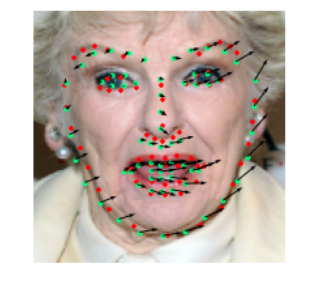
    
To do so is to apply a __second regressor__ that will learn to use new extracted feature that will perform a second minimization process on them.
</font>

# $\texttt{III. Series of regressors}$

<font size="3" >
In the following cell we will create a python class that will describe the working of a series of regressors . A python class is better for structuring such an algorithm, and allows us to save the regressors parameters $R$ and projection matrices $A$ as class attributes
</font>

In [ ]:
from sklearn.decomposition import PCA
from utils import create_transformation

class Regressor :
    def __init__(self,  real_images, real_landmarks, augmentation = 10 , n_components = 820) :
        self.n_components = n_components
        # Feature extractor
        self.sift = cv.SIFT_create()
        # Ground truth data
        self.real_landmarks = real_landmarks
        self.images = real_images
        self.trainset_size = len(self.images) * augmentation
        # Mean model
        self.mean_model = np.mean(real_landmarks, axis = 0)
        # 1st iteration, prepare data with the previous defined steps
        ## Landmarks
        self.ldk_ = create_transformation(self.mean_model, self.trainset_size, rotation = 15)
        self.ldk_ = np.array( [ ld.flatten() for ld in self.ldk_ ])
        self.ldk  = np.array( [ ld.flatten() for ld in real_landmarks for _ in range(augmentation)])
        ## Images
        self.img_ = [ im for im in real_images    for _ in range(augmentation)]
        ## Save
        self.R = []
        self.A = []
        self.LDK = [self.ldk_]
        # images to plot 
        self.ind = np.random.choice(np.arange(self.trainset_size), 5, replace = False)
        self.err_estim = [self.cost_fn(self.ldk, self.ldk_)]
    
    def fit(self, number_of_regressors):
        print("Initialization :")
        self.plot_samples_regression(self.img_, self.ldk, self.ldk_, self.err_estim[-1],  self.ind, n = 5 ,show_gt = True)
        print(f"Error : {np.mean(self.err_estim[-1]):9.5f}")
        for k in range(number_of_regressors):
            print("-"*110)
            print(f"Regressor {k} :")
            
            # 1. Extract descriptors on the new landmarks
            desc = self.extDesc(self.ldk_, self.img_)
            
            # 2. Compute the projection matrix
            Ak = self.computeProjectionMatrix(desc)
            # 3. Project the descriptors 
            desc = Ak @ desc.T
            # 4. Fit one regressors
            Rk, d_sk= self.oneStepAlignment(desc)
            
            # MAJ points and save
            self.ldk_ = self.majPoints(self.ldk_, d_sk)
            self.LDK.append(self.ldk_)
            
            # Compute cost function
            self.err_estim.append(self.cost_fn(self.ldk, self.ldk_))
            # plot regression results
            self.plot_samples_regression(self.img_, self.ldk, self.ldk_, self.err_estim[-1], self.ind, n = 5 ,show_gt = True)
            print(f"Error : {np.mean(self.err_estim[-1]):9.5f}")
            
            self.A.append(Ak)
            self.R.append(Rk)
    
    def cost_fn(self, ldk, ldk_):
        return np.linalg.norm(ldk - ldk_, axis = 1)
    
    def oneStepAlignment(self, desc):
        Y0 = np.vstack((desc , np.ones((1,  self.trainset_size))))
        delta_s = self.ldk - self.ldk_
        R0 =   (delta_s.T @ Y0.T) @ np.linalg.inv( Y0 @ Y0.T)
        return R0, R0 @ Y0
    
    def computeProjectionMatrix(self, desc):
        for i in  tqdm(range(1), ncols = 100, desc =f"Projection mat.\t") :
            pca = PCA(self.n_components)
            pca.fit(desc)
        return pca.components_
        
        
    def majPoints(self, sk, d_sk):
        return sk + d_sk.T
    
    def extDesc(self, landmarks, images) :
        desc = []
        for i in  tqdm(range(0, len(images)), ncols = 100, desc =f"Extract desc.\t") :
            d = self._extDesc(landmarks[i], images[i])
            desc.append(d)
        return np.array(desc)
        
    def _extDesc(self, landmark, image):
        landmark = landmark.reshape(68,2)
        keypoints = [ cv.KeyPoint(*ld, size = 20) for ld in landmark] 
        kp, desc = self.sift.compute(image, keypoints)
        return desc.flatten()
    
    def plot_samples_regression(self, images, real_landmarks, displacement, err, indices, n = 5, show_gt = True):
        max_faces_per_row = 5
        rows, columns = n//max_faces_per_row + 1 , min(n, max_faces_per_row)
        figure_width  = min(4*columns, 20)
        figure_height = 4*rows
        fig = plt.figure( figsize = (figure_width, figure_height))
        fig.tight_layout()
        for i, ind  in enumerate(indices) :
            ax =  fig.add_subplot(rows, columns, i + 1)
            ax.imshow(images[ind], cmap ='gray')
            # plot real landmarks
            if show_gt :
                ldks = real_landmarks[ind].reshape(-1,2).T
                ax.scatter(*ldks, s = 25, color = 'red', marker = '+',linewidths = 1.2, alpha =  0.8)
            # plot estimated landmarks
            ldks_ = displacement[ind].reshape(-1,2).T
            ax.scatter(*ldks_, s = 12, alpha = 0.8, color = '#00ff7f')
            # Cost fn
            if show_gt :
                ax.set_title(f"cost : {err[ind]:9.4f}")
            ax.axis(False)
        plt.show()
        
    def test(self, test_images, test_landmarks, show_gt = True) :
        # Testset size
        testset_size = len(test_images)
        # Landmarks
        ldk  = np.array([ ld.flatten() for ld in test_landmarks])
        ldk_ = np.array([ mean_model.flatten() for _ in range(testset_size)])
        # Choose randoom samples to plot
        indices = np.random.choice(np.arange(testset_size), 5, replace = False)
        # Inititalization
        print("Initialization :")
        self.plot_samples_regression(test_images, ldk, ldk_, self.cost_fn(ldk, ldk_), indices, n = 5 ,show_gt = show_gt)
        err = []
        err.append(self.cost_fn(ldk, ldk_))
        for i in range(len(self.R)):
            print("-"*110)
            desc = self.extDesc(ldk_, test_images)
            # Project description
            desc = self.A[i] @ np.array(desc).T
            # regression
            Y0 = np.vstack((desc , np.ones((1,  testset_size))))
            ldk_ = self.majPoints(ldk_, self.R[i]@Y0)
            cc = self.cost_fn(ldk, ldk_)
            self.plot_samples_regression(test_images, ldk, ldk_, cc, indices, n = 5, show_gt=show_gt)
            if show_gt : 
                print(f"Error : {np.mean(cc):9.5f}")
            err.append(cc)
        return err

In [ ]:
# Initialize the training instance with a the train images and train landmarks
n_components = 620
reg = Regressor( train_images, train_landmarks, augmentation = 10, n_components = n_components)

In [ ]:
number_of_regressors = 5
reg.fit(number_of_regressors = number_of_regressors)

In [ ]:
err = reg.test(test_images, test_landmarks)

In [ ]:
# plot the train and test errors
plt.figure(figsize = (8, 6))
plt.plot(np.mean(reg.err_estim, axis = 1), label = "train")
plt.plot(np.mean(err, axis = 1), label = "test")
plt.legend()
plt.grid()
plt.ylabel("Cost function")
plt.xlabel("Regressor")
plt.title("The prediction error on each regressor")
plt.show()

<font size="3" >
    
We can see from the previous plot, the improvement that brings each layer of regression to the global loss. As explained earlier the first layer of regression performs a general approximation of the solution (it doesn't bother with the fine details). The following layers of regression performs a finer approximation since the model approaches more and more the real solution.
    
However, some face orientations are more difficult to work with since they aren't well represented in the trainset. Thus, the model performs better on faces that have "normal" face orientation, since they're well represented in the trainset.
    
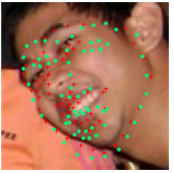  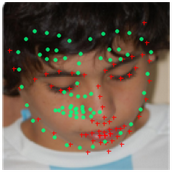
    

A solution to this would be to increase the embedding dimension of the PCA, which could keep more variance of the dataset and represent some specific samples.  Another solution would be to adapt the mask proposals on the initialization phase, by generating more samples at the center of the image than the extremities since we surely know that the bounding box prevent the presence of faces outside the image. We mean by that that the translation parameters can be described by a normal distribution, this to condense normal translations in the center of the image.
    
</font>